In [56]:
%matplotlib inline

In [57]:
from IPython.display import clear_output
from pathlib import Path
from PIL import Image

import glob
import os
import pprint
import random
import shutil
import tarfile
import time
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import torch.nn.functional as F
import torchvision.transforms as T

In [58]:
def show_image(data, class_list=None):
    image, label = data
    image = image.numpy().transpose((1, 2, 0))
        
    if class_list:
        label = class_list[label]
        
    plt.title(label)
    plt.imshow(image)

In [59]:
def print_training_history(history):
    training_steps = np.array([step for step, _ in history])
    loss = np.array([loss for _, loss in history])

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.plot(training_steps, loss)

    ax.set(xlabel='training_steps', ylabel='loss')
    ax.grid()
    plt.show()

In [60]:
def model_evaluate(model, test_loader):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        t = time.time()
        for i, (inputs, label) in enumerate(test_loader):
            inputs, label = inputs.to(device), label.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            print(label.size(0))
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
            t = time.time() - t

            clear_output(wait=True)
            print("Batch     | Time(s)")
            print("-------------------")
            print(f"{i + 1:5d} / {len(test_loader):5d} | {int(t):7d}")

            
    accuracy = 100 * correct / total
            
    print(f'Accuracy of the network on {len(test_loader.dataset)} test images: {accuracy:.1f} %')
    return accuracy

In [61]:
def mixup_data(x, y, alpha=0.1, use_cuda=True):
    # This is code from the authors of the paper
    # https://arxiv.org/abs/1710.09412
    
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        # Note, this means that MixUp does nothing.
        lam = 1
    
    batch_size = x.size()[0]
    
    if use_cuda:
        # This shuffles our indices and sends these indices to the GPU
        index = torch.randperm(batch_size).cuda()
    else:
        # This shuffles our indices without sending them to the GPU
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [62]:
def save_model(model, dataset, epoch, opt, scheduler, loss_history=None):
    
    model_name = model.__class__.__name__
    dataset_name = dataset.__class__.__name__
    t = int(time.time())
    
    if dataset_name:
        ckpt_path = '/workspace/models/' + model_name + '_' + dataset_name + f"_{t}.ckpt"
    else:
        ckpt_path = '/workspace/models/' + model_name + f"_{t}.ckpt"
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler': scheduler.state_dict(),
            'loss_history': loss_history
            }, ckpt_path)

    return ckpt_path

In [63]:
def load_model(model, path):
    
    ckpt_dict = torch.load(path)
    
    model.load_state_dict(ckpt_dict['model_state_dict'])
    
    return ckpt_dict

In [64]:
def make_prediction(model, image, transforms, device=None, dataset=None):
    # Image input is assumed to be an image of height, width, channel.
    # Class list has a list of the objects classification.
    
    model.to(device)
    
    image = transforms(image)
    image.to(device)
    if len(image.shape) < 4:
        image = image.unsqueeze(0)
    image = image.to(device)
    
    pred = model(image)
    pred = torch.nn.Softmax(dim=1)(pred)
    pred = pred.squeeze(0)
    confidence = pred
    pred = torch.argmax(pred).item()
    
    final_pred = (dataset.classes[pred], confidence[pred].item()) if dataset else (pred, confidence[pred].item())
    
    return final_pred

In [65]:
def one_batch_train_mixup(model, images, label, use_cuda, alpha=0.1):
    mixed_x, y_a, y_b, lam = mixup_data(images, label, alpha=alpha, use_cuda=use_cuda)
    pred = model(mixed_x)

    loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
    
    return loss

In [66]:
def train(model, criterion, opt, train_dl, test_dl, start_epoch=0, scheduler=None,
          mixup=False, mixup_pct=0.0, use_amp=False, checkpoint=0, loss_history=None,
          use_swa=False, swa_start=0, swa_lr=3e-4, epochs=23, evaluate=True):
    
    # The history of our training, inputs step, loss pair.
    
    history = loss_history if loss_history else []
    
    # Initialize step
    step = 1
    
    # This is the code that allows us to use our GPU to train.
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    model.to(device)
    
    if use_swa:
        swa_scheduler = torch.optim.swa_utils.SWALR(opt, anneal_strategy="linear", anneal_epochs=5, swa_lr=swa_lr)
        swa_model = torch.optim.swa_utils.AveragedModel(model)
    
    # This controls how many iterations we want to make, which helps control how well our model
    # generalizes.
    total_time = time.time()
    
    if use_amp:
        scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(start_epoch, epochs):

        # Initializing the time for informational purposes.
        t = time.time()
        batch_start = t

        #This is how we get our inputs and labels from our dataloader.
        for i, (images, label) in enumerate(train_dl):
            # We have to zero out our gradients, because they can get too large.
            opt.zero_grad(set_to_none=True)

            # This sends the inputs and the labels to our device.
            images, label = images.to(device), label.to(device)
            
            # This is the prediction of our model
            if mixup and random.random() < mixup_pct:
                loss = one_batch_train_mixup(model, images, label, use_cuda=use_cuda, alpha=0.1)
            else:
                pred = model(images)
            
                # Remember loss functions take two inputs, the prediction and the label.
                loss = criterion(pred, label)
            
            # This step gets our gradients.
            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                
            if use_swa and epoch > swa_start:
                swa_model.update_parameters(model)
                swa_scheduler.step()
            else:
                # This is how we update our neural network weights. 
                opt.step()
            
            # Append current step and loss.
            history.append((step, loss.item()))
            step += 1

            # Get time Batch training is taking.
            t = time.time() - batch_start

            # Gives a nice representation of how our training is progressing.
            clear_output(wait=True)
            print("Epoch | Batch | Time(s) | Loss")
            print("------------------------------")
            print(f"{epoch + 1:5d} | {i + 1:5d} | {int(t):7d} | {loss:.5f}")
        
        print(f"Finished epoch {epoch + 1}.")
        
        if scheduler:
            scheduler.step()
        
        if checkpoint and ((epoch + 1) % checkpoint == 0):
            save_model(model, train_dl.dataset, epoch, opt, scheduler, loss_history=history)
        
    if use_swa and epochs > swa_start:
        torch.optim.swa_utils.update_bn(train_dl, model, device=device)
    
    total_time = time.time() - total_time
    print(f"Finished Training in {int(total_time)} seconds!")
    if evaluate:
        print("Evaluating")
        model_evaluate(model, test_dl)
        
    print(f"Saving model!")
    save_model(model, train_dl.dataset, epoch, opt, scheduler, loss_history=history)
    
    return history

In [67]:
def save_to_onnx(model, input_shape, path=None):
    bs, c, h, w = input_shape
    
    dummy_input = torch.randn(bs, c, h, w, device='cuda')
    
    model.to('cuda')
    
    input_names = [ "input" ]
    output_names = [ "output" ]
    
    if not path:
        path = model.__class__.__name__ + '.onnx'
    
    torch.onnx.export(model, dummy_input, path, verbose=True, input_names=input_names, output_names=output_names)
    
    return path

In [68]:
class TransformDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, transform, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform=target_transform
        self.name = 'Lakota_Plants'
        
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        label = self.dataset[idx][1]
        
        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def __len__(self):
        return len(self.dataset)

# Extract the Training and Test Data

Currently we only have training data, but this will be extracted in the next cell.

In [ ]:
# Check if plant_data is made.
if not os.path.isdir('/workspace/data/plant_data/'):
    os.mkdir('/workspace/data/plant_data')

# Extract data.
with tarfile.open("/workspace/data/2022_laicc_plant_data.tar.gz", 'r:gz') as tar:
    tar.extractall('/workspace/data/')

# Hyperparameters

These are the variables that you will change to make your model run better or faster.
All of your hyperparameters are below and you will make changes here.

In [88]:
hparams = {
    'lr': 3e-3,
    'num_classes': 6, # Don't change
    # Decide whether you want to add mixup training and how often it is run..
    'mixup': True,
    'mixup_pct': 0.90,
    # Automatic Mixed Precision, should speed up training.
    'use_amp': True,
    # Epochs - how long you want to train
    'epochs': 15,
    'start_epoch': 0,
    # Pin the memory, this should speed up training, but could make the kernel more stable
    'pin_memory': True, # Don't change
    # This is your batch size.
    'bs': 16,
    # Whether or not to use stochastic weight averaging. Setting to true should increase test accuracy.
    # If use_swa is set to False, then swa_start and swa_lar is not used.
    'use_swa': False,
    'swa_start': 12,
    'swa_lr': 5e-3,
    # How many epochs to train before saving model. If set to 0, checkpointing will not be performed.
    'checkpoint': 5,
    # Where your training data is stored.
    'train_root': '/workspace/data/plant_data/', # Do not change
    # Where your test data is stored.
    'test_root': '/workspace/data/plant_data/', # Do not change
    # This should be a number and how often you should save your data.
    'num_workers': 4,
    # If you want to restart training, change this to the path of the checkpoint you wish to start at.
    'ckpt_path': None, #'/workspace/models/ResNet_Lakota_Plants_1658958130.ckpt',
}

### Transforms

Define your transforms below. The minimal transform input is included below, but you can and should add more.
Select new transforms from [Pytorch Transforms](https://pytorch.org/vision/main/transforms.html#transforms)

In [89]:
transforms = T.Compose(
    [T.Resize(size=(246, 246)),
     T.CenterCrop([224]),
     T.AugMix(),
     #T.RandomPerspective(),
     #T.RandomHorizontalFlip(p=0.5),
     #T.RandomVerticalFlip(p=0.5),
     #T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1)),
     #T.RandomRotation(degrees=(0, 10)),
     T.Grayscale(num_output_channels=3),
     T.ToTensor(),
     T.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]), std=torch.tensor([0.229, 0.224, 0.225])),
    ])

test_transforms = T.Compose(
    [T.Resize(size=(246, 246)),
     T.CenterCrop([224]),
     T.Grayscale(num_output_channels=3),
     T.ToTensor(),
     T.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]), std=torch.tensor([0.229, 0.224, 0.225])),
    ])

# Initialize the Dataset

We will initialize our dataset using the transforms above.

In [90]:
# Initialize your training dataset by setting train=True
base_ds = torchvision.datasets.ImageFolder(root=hparams['train_root'], transform=None,
                                            target_transform=None, loader=Image.open,
                                            is_valid_file=None)

In [92]:
train_split, test_split = torch.utils.data.random_split(base_ds, [len(base_ds) - 50, 50],
                                                  generator=torch.Generator().manual_seed(38))

In [93]:
train_ds = TransformDataset(train_split, transform=transforms)

test_ds = TransformDataset(test_split, transform=test_transforms)

In [94]:
train_ds.__class__.__name__ = 'Lakota_Plants'

In [95]:
class_weights = [0 for _ in range(len(base_ds.classes))]

for _, label in train_split:
    class_weights[label] += 1

In [96]:
# These class weights are based on torch.Generator().manual_seed(38)

class_weights = 1 / torch.tensor(class_weights, dtype=torch.float)

In [97]:
weighted_sampler = torch.utils.data.WeightedRandomSampler(class_weights, 5000, replacement=True, generator=None)

In [98]:
# Initialize your dataloader
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=hparams['bs'],
                                       shuffle=False,
                                       sampler=weighted_sampler,
                                       num_workers=hparams['num_workers'],
                                       persistent_workers=True,
                                       pin_memory=hparams['pin_memory'])
test_dl = torch.utils.data.DataLoader(test_ds,
                                      batch_size=hparams['bs'],
                                      shuffle=False,
                                      sampler=None,
                                      num_workers=hparams['num_workers'],
                                      persistent_workers=False,
                                      pin_memory=hparams['pin_memory'])

In [117]:
# Select your model from the following link:
# https://pytorch.org/vision/stable/models.html#classification

model = torchvision.models.vit_b_16(pretrained=True)

In [118]:
model.heads.head = torch.nn.Linear(model.heads.head.in_features, hparams['num_classes'])

In [119]:
for name, param in model.named_parameters():
    if not 'heads' in name:
        param.requires_grad = False

In [120]:
# Since we are doing classification, we will always use this loss.

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0)

In [123]:
opt = torch.optim.SGD(model.parameters(), lr=hparams['lr'], momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=hparams['lr'], max_lr=10*hparams['lr'],
                                          step_size_up=1000, mode='triangular',
                                          cycle_momentum=False)
#scheduler2 = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)

#scheduler = torch.optim.lr_scheduler.ChainedScheduler([scheduler1, scheduler2])

# Optimizers

You can select one of the following optimizers.
For all of these, `params=model.parameters()`

- `torch.optim.Adadelta(params, lr=1, rho=0.9, eps=1e-06, weight_decay=0)`
- `torch.optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, eps=1e-10)`
- `torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)` use lr=3e-4 or close to it for Adam.
- `torch.optim.AdamW(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)`
- `torch.optim.ASGD(params, lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)`
- `torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)`
- `torch.optim.SGD(params, lr=0.001, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

In [124]:
if hparams['ckpt_path']:
    ckpt_dict = torch.load(hparams['ckpt_path'])
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model.load_state_dict(ckpt_dict['model_state_dict'], strict=False)
    opt.load_state_dict(ckpt_dict['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt_dict['scheduler'])
    hparams['start_epoch'] = ckpt_dict['epoch']
    for state in opt.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    
else:
    ckpt_dict = {
            'epoch': 0,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler': scheduler.state_dict(),
            'loss_history': None,
    }

In [ ]:
# Call to begin training
# Change the value of epochs
history = train(model, criterion, opt, train_dl, test_dl, start_epoch=hparams['start_epoch'], 
                scheduler=scheduler, mixup=hparams['mixup'], mixup_pct=hparams['mixup_pct'],
                use_amp=hparams['use_amp'], checkpoint=hparams['checkpoint'],
                loss_history=ckpt_dict['loss_history'], use_swa=hparams['use_swa'],
                swa_start=hparams['swa_start'], swa_lr=hparams['swa_lr'],
                epochs=hparams['epochs'], evaluate=True)

Epoch | Batch | Time(s) | Loss
------------------------------
   15 |    12 |     111 | 0.00750


In [ ]:
print_training_history(history)

In [108]:
y_true = []

for _, label in test_split:
    y_true.append(label)

In [109]:
set(y_true)

{0, 1, 2}

In [110]:
y_pred = []

model.to('cuda')

for image, _ in test_dl:
    
    model.eval()
    
    image = image.to('cuda')
    
    with torch.no_grad():
        preds = torch.nn.Softmax(dim=1)(model(image))
        labels = torch.argmax(preds, dim=1)
        labels = torch.flatten(labels)
        labels = [l.item() for l in labels]
        y_pred.append(labels)

In [111]:
y_pred = [item for sublist in y_pred for item in sublist]

In [112]:
set(y_pred)

{1, 2}

In [113]:
len(y_pred)

50

In [114]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [115]:
cfm = confusion_matrix(y_true, y_pred)

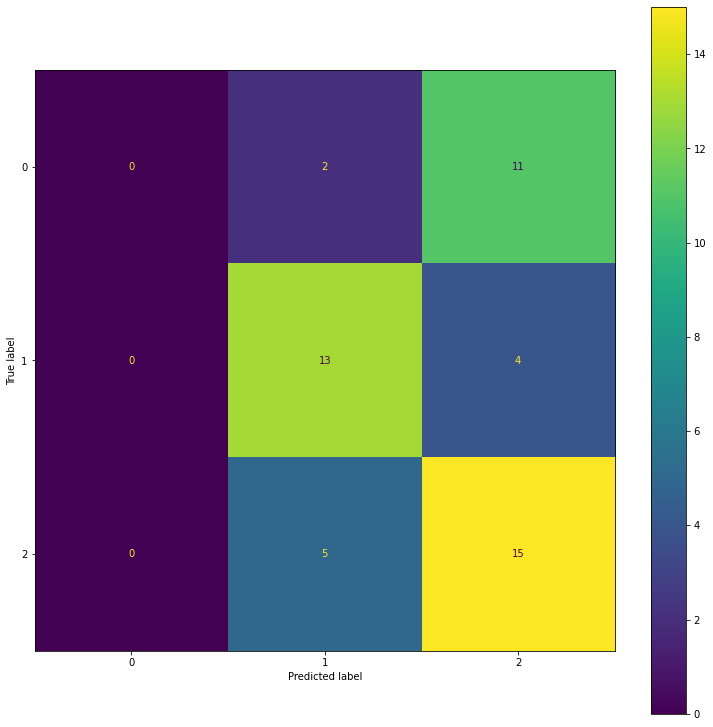

In [116]:
disp = ConfusionMatrixDisplay(confusion_matrix=cfm,
                              display_labels=base_ds.classes)
                              #display_labels=[i for i in range(len(base_ds.classes))])


fig, ax = plt.subplots(figsize=(13,13))
disp.plot(ax=ax)
plt.savefig('cfm_resnext_lakota_plant_data.png', format='png')

In [ ]:
base_ds.classes

In [ ]:
# To make a prediction, paste the path to the image below.
# # img_path = '/workspace/data/plant_data/Purple_Coneflower/20220716_230129.jpg'

# img = Image.open(img_path)

In [ ]:
# make_prediction(model.to('cuda'), img, test_transforms, device='cuda', dataset=base_ds)

In [ ]:
model = torch.nn.Sequential(
    model,
    torch.nn.Softmax(dim=1)
)

In [ ]:
# IF you are satisfied with your models performance, save to ONNX
# You need to change your input shape. It should be of the form
# (batch_size, num_channels, height, width)
# You will get height and width from the transform
# T.Resize(size=(224, 224)), which would mean we would have
input_shape = (10, 3, 224, 224)


path = f'/workspace/models/{model.__class__.__name__}_{int(time.time())}.onnx'

save_to_onnx(model, input_shape, path=path)